In [ ]:
# ### 1. Download the Dataset
#
# The dataset is cloned from a GitLab repository. This contains the
# 'Health_and_Personal_Care_5.json' file we will be using.
print("--- Step 1: Downloading the dataset ---")
!git clone https://gitlab.com/sayantan.world98/sentiment-analysis-amazon-health-and-personal-care.git
print("\n✅ Dataset downloaded successfully.\n")

--- Step 1: Downloading the dataset ---
Cloning into 'sentiment-analysis-amazon-health-and-personal-care'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 38 (delta 9), reused 38 (delta 9), pack-reused 0 (from 0)
Receiving objects: 100% (38/38), 82.19 MiB | 10.35 MiB/s, done.
Resolving deltas: 100% (9/9), done.
Updating files: 100% (7/7), done.

✅ Dataset downloaded successfully.



In [ ]:
# ### 2. Import Necessary Libraries
#
# Import all the required libraries for data manipulation, visualization,
# text preprocessing, and machine learning.
print("--- Step 2: Importing libraries ---")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import string
import re
import pickle
import warnings
warnings.filterwarnings('ignore')
print("✅ Libraries imported successfully.\n")


--- Step 2: Importing libraries ---
✅ Libraries imported successfully.



In [ ]:
# ### 3. Load and Prepare the Data
#
# Load the JSON data into a pandas DataFrame and perform initial preprocessing
# to create a balanced binary classification dataset.
print("--- Step 3: Loading and Preparing Data ---")

# Load the dataset
df = pd.read_json('/content/sentiment-analysis-amazon-health-and-personal-care/dataset/Health_and_Personal_Care_5.json', lines=True)
print(f"Original dataset loaded with {df.shape[0]} reviews.")
print("Original rating distribution:")
print(df['overall'].value_counts())

# We will classify reviews as positive (1) or negative (0).
# Ratings of 4 or 5 are positive. Ratings of 1 or 2 are negative.
# We ignore neutral reviews (rating 3) for this binary classification task.

# Create a score based on helpfulness to sample more relevant reviews
df['score'] = df.helpful.apply(lambda x: x[0] / (x[1] + 2))

# Separate positive and negative reviews
df_pos = df[(df.overall == 5) | (df.overall == 4)]
df_neg = df[(df.overall == 1) | (df.overall == 2)]

# The dataset is imbalanced. We will create a balanced dataset by sampling
# 32,000 reviews from each class.
df_pos = df_pos.sample(n=32000, weights=df.score, random_state=42)
df_neg = df_neg.sample(n=32000, random_state=42)

# Combine the positive and negative samples into a single DataFrame
df_all = pd.concat([df_pos, df_neg])

# Define a function to convert ratings (5,4,2,1) into binary sentiment scores (1,0)
def sentiment_score(n):
    return 1 if n in [4, 5] else 0

df_all['overall'] = df_all['overall'].apply(sentiment_score)

print("\nBalanced dataset created.")
print("New sentiment distribution:")
print(df_all['overall'].value_counts())

# Remove unnecessary columns
df_all = df_all.drop(['reviewerName', 'helpful', 'unixReviewTime', 'reviewTime', 'score', 'summary', 'asin', 'reviewerID'], axis=1)
df_all = df_all.reset_index(drop=True)
print("\n✅ Data preparation complete.\n")

--- Step 3: Loading and Preparing Data ---
Original dataset loaded with 346355 reviews.
Original rating distribution:
overall
5    211633
4     68168
3     33254
2     16754
1     16546
Name: count, dtype: int64

Balanced dataset created.
New sentiment distribution:
overall
1    32000
0    32000
Name: count, dtype: int64

✅ Data preparation complete.



In [ ]:
# ### 4. Text Preprocessing
#
# Clean the review text by converting to lowercase, removing punctuation,
# filtering out stopwords, and performing lemmatization.
print("--- Step 4: Text Preprocessing ---")

# Download necessary NLTK data
print("Downloading NLTK resources (stopwords, punkt, wordnet, punkt_tab)...")
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt_tab', quiet=True)  # Download punkt_tab
print("NLTK resources downloaded.")

stopword = set(stopwords.words('english'))
wordLemm = WordNetLemmatizer()

def process_reviews(review):
    review = review.lower()
    review = review.translate(str.maketrans("", "", string.punctuation))
    tokens = word_tokenize(review)
    final_tokens = [w for w in tokens if w not in stopword]
    finalwords = [wordLemm.lemmatize(w) for w in final_tokens if len(w) > 1]
    return ' '.join(finalwords)

# Ensure all reviewText entries are strings before processing
df_all['reviewText'] = df_all['reviewText'].astype('str')

# Apply the processing function to the review text
df_all['processed_reviews'] = df_all['reviewText'].apply(process_reviews)
print("\n✅ Text preprocessing complete.\n")

--- Step 4: Text Preprocessing ---
NLTK resources downloaded.

✅ Text preprocessing complete.



In [ ]:
# ### 5. Feature Extraction (TF-IDF) and Data Splitting
#
# Convert the processed text into numerical vectors using TF-IDF and
# split the data into training and testing sets.
print("--- Step 5: Feature Extraction and Data Splitting ---")
X = df_all['processed_reviews'].values
y = df_all['overall'].values

# Convert text to word frequency vectors using TF-IDF
vector = TfidfVectorizer(sublinear_tf=True)
X_tfidf = vector.fit_transform(X)
print(f"TF-IDF vectorization complete. Shape of feature matrix: {X_tfidf.shape}")

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.20, random_state=42)
print(f"Data split into training ({X_train.shape[0]} samples) and testing ({X_test.shape[0]} samples) sets.")
print("✅ Feature extraction and splitting complete.\n")

--- Step 5: Feature Extraction and Data Splitting ---
TF-IDF vectorization complete. Shape of feature matrix: (64000, 139561)
Data split into training (51200 samples) and testing (12800 samples) sets.
✅ Feature extraction and splitting complete.



--- Step 6: Model Training and Evaluation ---
Accuracy on training data: 88.67%
Accuracy on testing data:  84.44%

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.84      0.84      6460
           1       0.84      0.85      0.84      6340

    accuracy                           0.84     12800
   macro avg       0.84      0.84      0.84     12800
weighted avg       0.84      0.84      0.84     12800



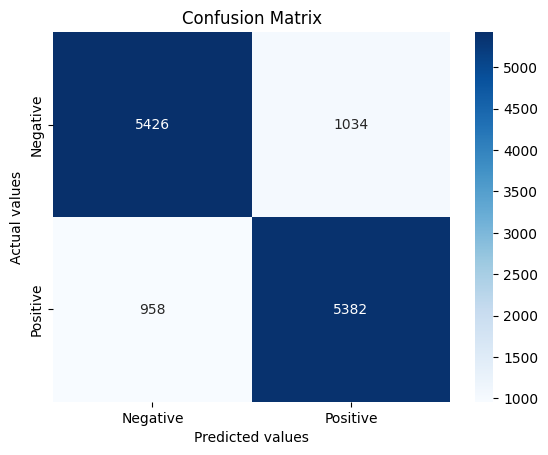


✅ Model training and evaluation complete.



In [ ]:
# ### 6. Model Training and Evaluation
#
# Train a Logistic Regression model and evaluate its performance.
print("--- Step 6: Model Training and Evaluation ---")

# Define a function to evaluate the model
def model_Evaluate(model):
    print('Accuracy on training data: {:.2f}%'.format(model.score(X_train, y_train) * 100))
    print('Accuracy on testing data:  {:.2f}%\n'.format(model.score(X_test, y_test) * 100))
    y_pred = model.predict(X_test)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative', 'Positive']
    sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
    plt.xlabel("Predicted values")
    plt.ylabel("Actual values")
    plt.title("Confusion Matrix")
    plt.show()

# Train the Logistic Regression model
lg = LogisticRegression()
lg.fit(X_train, y_train)

# Evaluate the model
model_Evaluate(lg)
print("\n✅ Model training and evaluation complete.\n")



In [ ]:
# ### 7. Model Saving and Prediction
#
# Save the trained model and the vectorizer for future use. Then, create a
# prediction pipeline to classify new, unseen reviews.
print("--- Step 7: Model Saving and Prediction Pipeline ---")

# Save the vectorizer and model using pickle
with open('vectoriser.pickle', 'wb') as f:
    pickle.dump(vector, f)
with open('logisticRegression.pickle', 'wb') as f:
    pickle.dump(lg, f)
print("Vectorizer and Logistic Regression model saved to files.")

# Define functions to load the models and make predictions
def load_models():
    with open('vectoriser.pickle', 'rb') as f:
        vectoriser = pickle.load(f)
    with open('logisticRegression.pickle', 'rb') as f:
        lg_model = pickle.load(f)
    return vectoriser, lg_model

def predict(vectoriser, model, text_list):
    processed_text = [process_reviews(sen) for sen in text_list]
    textdata = vectoriser.transform(processed_text)
    sentiment = model.predict(textdata)
    df_result = pd.DataFrame({'text': text_list, 'sentiment': sentiment})
    df_result['sentiment'] = df_result['sentiment'].replace([0, 1], ["Negative", "Positive"])
    return df_result

# --- Prediction Example ---
# Load the saved models
vectoriser, loaded_lg = load_models()

# Example reviews to classify (includes positive, negative, and a sarcastic one)
text_to_predict = [
    "Such an amazing trimmer. It is a must buy for anyone who is thinking to buy a trimmer. Completely satisfied with the purchase.",
    "Absolute garbage. Do not buy this, I would give this zero star if possible.",
    "Definitely worth it if you can sell one of your kidney to afford it. The price makes it really unique from all other products."
]

print("\n--- Predicting on New Reviews ---")
predictions_df = predict(vectoriser, loaded_lg, text_to_predict)
print(predictions_df)
print("\nNote: The sarcastic review is misclassified as 'Positive', a known limitation of this model.")
print("✅ Prediction pipeline demonstrated.\n")
print(">>> Experiment Complete <<<")


--- Step 7: Model Saving and Prediction Pipeline ---
Vectorizer and Logistic Regression model saved to files.

--- Predicting on New Reviews ---
                                                text sentiment
0  Such an amazing trimmer. It is a must buy for ...  Positive
1  Absolute garbage. Do not buy this, I would giv...  Negative
2  Definitely worth it if you can sell one of you...  Positive

Note: The sarcastic review is misclassified as 'Positive', a known limitation of this model.
✅ Prediction pipeline demonstrated.

>>> Experiment Complete <<<
